# Test for photometry

- SDSS http://skyserver.sdss.org/dr16/en/tools/search/sql.aspx
- https://astroquery.readthedocs.io/en/v0.1-0/_generated/astroquery.sdss.core.SDSS.html

In [366]:
import pandas as pd
import scipy
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt

## Photutils
- https://photutils.readthedocs.io/en/stable/#user-documentation

In [ ]:
from astropy.io import fits

In [462]:
hdul = fits.open('1915/R3044.fits')
hdul.info()
image = hdul[0].data.astype(float) #data[500:1000, 500:1000]

Filename: 1915/R3044.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     457   (3839, 3839)   int16 (rescales to uint16)   


In [463]:
image -= np.median(image)

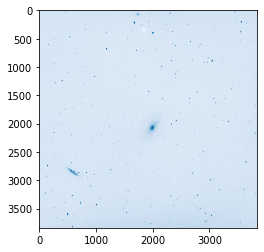

In [464]:
plt.imshow(image, cmap = 'Blues')

In [466]:
from photutils import DAOStarFinder
from astropy.stats import mad_std
bkg_sigma = mad_std(image)  
daofind = DAOStarFinder(fwhm=10., threshold=5.*bkg_sigma)  #10.
sources = daofind(image)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id  xcentroid ycentroid sharpness  ... sky  peak    flux       mag     
---- --------- --------- ---------- ... --- ----- --------- ------------
   1 1550.9012 2.9653994 0.53550066 ...   0  2492 1.0966554  -0.10017548
   2 2072.6738 3.6592246 0.24517264 ...   0  2137 1.1353378  -0.13781272
   3 2151.3342 3.2903377 0.45302598 ...   0  3502 1.2230615  -0.21862076
   4 3214.8808 3.1000996 0.69993473 ...   0  3510 1.1580474  -0.15931582
   5 3439.5707 2.9205763 0.56580643 ...   0  3989 1.4425617    -0.397836
   6 3807.1733 3.2384064 0.28444502 ...   0  2188 1.2331637  -0.22755186
   7 935.25926 3.4342015 0.33010496 ...   0  2779 1.2262478  -0.22144562
   8 1528.9611  3.635107 0.58484453 ...   0  2561  1.012267 -0.013237684
   9 2437.1645 3.8925547 0.54960877 ...   0  3116 1.0737498 -0.077257741
  10  2694.734 5.0295345 0.40883638 ...   0  2555 1.0250691 -0.026882874
 ...       ...       ...        ... ... ...   ...       ...          ...
4639 1930.4995 3833.6501 0.48235352 ...   0  6232 1

In [467]:
from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=4.)  
phot_table = aperture_photometry(image, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id   xcenter   ycenter  aperture_sum
        pix       pix                
---- --------- --------- ------------
   1 1550.9012 2.9653994    83344.393
   2 2072.6738 3.6592246    115904.87
   3 2151.3342 3.2903377    150236.29
   4 3214.8808 3.1000996    109389.26
   5 3439.5707 2.9205763    141651.26
   6 3807.1733 3.2384064    112254.09
   7 935.25926 3.4342015     122847.1
   8 1528.9611  3.635107    80882.155
   9 2437.1645 3.8925547    110726.67
  10  2694.734 5.0295345    111876.39
 ...       ...       ...          ...
4640 2533.5499 3835.3446      1406292
4641 2605.9446 3833.2325    271289.83
4642 3105.4247  3833.488    232453.05
4643 3509.6015 3833.3086    204321.91
4644  3629.335   3832.76    195824.02
4645  3729.186 3833.3974    177238.17
4646 3833.6163 3833.4416    134895.56
4647 198.71126  3834.591    105325.74
4648 1249.8723 3833.1573    220887.64
4649 1804.6848 3834.1031    222336.67
Length = 4649 rows


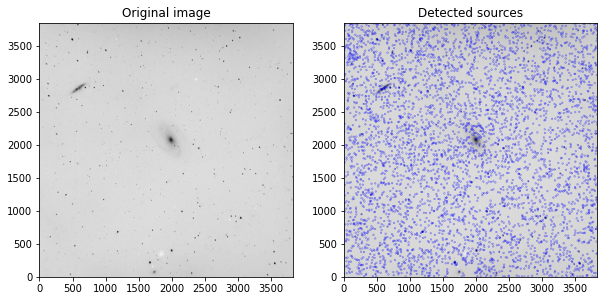

In [468]:
fig, axes = plt.subplots(1,2, figsize = (10,50))
axes[0].set_title('Original image')
axes[0].imshow(image, cmap='gray_r', origin='lower')
axes[1].set_title('Detected sources')
axes[1].imshow(image, cmap='gray_r', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
#plt.savefig('test.png')

In [474]:
from astropy.wcs import WCS
w = WCS('1915/R3044.fits')

In [488]:
df = phot_table.to_pandas()
radec = df.apply(lambda row: w.all_pix2world(row['xcenter'], row['ycenter'], 0), axis = 1)
df_radec = pd.DataFrame(list(radec), columns =['ra', 'dec'])
df = pd.concat([df, df_radec], axis=1)

In [489]:
df

,id,xcenter,ycenter,aperture_sum,ra,dec
0,1,1550.901246,2.965399,83344.393318,151.0080037353423,68.78050124753551
1,2,2072.673793,3.659225,115904.865660,150.70203473602749,68.61243994254374
2,3,2151.334175,3.290338,150236.291168,150.6567204270616,68.58695538249499
3,4,3214.880819,3.100100,109389.264729,150.0497912757359,68.2421952331888
4,5,3439.570740,2.920576,141651.257449,149.92402778554265,68.16905200609031
...,...,...,...,...,...,...
4644,4645,3729.186035,3833.397358,177238.165965,146.3224694521519,68.83057556006659
4645,4646,3833.616310,3833.441584,134895.557744,146.26816309351864,68.7953550020413
4646,4647,198.711262,3834.590979,105325.739825,148.26245243271575,70.01089832392903
4647,4648,1249.872276,3833.157326,220887.640758,147.66346963070333,69.66159646122698


## Others
- https://github.com/bkornpob/photometry
- https://photometrypipeline.readthedocs.io/_/downloads/en/latest/pdf/

## Get data from SDSS

In [9]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import matplotlib.pyplot as plt

In [50]:
def get_SDSS(apt, fig_path):
    pos = coords.SkyCoord(apt['CentroidRA'].mean(), apt['CentroidDec'].mean(), frame='icrs', unit='deg')
    rad = (max(apt3044['CentroidRA']) - min(apt3044['CentroidRA']))*60/2 #arcmin radius
    xid = SDSS.query_region(pos, radius = rad * u.arcmin, spectro = False, fields = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z']) 
    dfSDSS = xid.to_pandas()
    plt.scatter(dfSDSS['ra'], dfSDSS['dec'], alpha = 0.3)
    plt.scatter(apt['CentroidRA'], apt['CentroidDec'], alpha = 0.3)
    plt.savefig(fig_path)
    plt.clf()
    return dfSDSS

In [55]:
# for csv in csv_list:
#     path = "1915/" + csv[:-4]
#     apt = pd.read_csv("1915/" + csv)
#     fig_path = path + '.png'
#     dfSDSS = get_SDSS(apt, fig_path)
#     dfSDSS.to_csv(path + '_SDSS.csv', index = False) 

## Match tables
- Correct for proper motion?

In [57]:
def match(cal, apt):
    df = pd.DataFrame(columns=['ra', 'dec', 'u', 'g','r','i', 'z', 'CentroidRA','CentroidDec','Magnitude','diff'])
    dist = scipy.spatial.distance.cdist(apt[['CentroidRA', 'CentroidDec']], cal[['ra', 'dec']])
    min_dist = np.argmin(dist, axis=1)

    m = 0
    while m < len(apt):
        n = min_dist[m]
        df = df.append({'ra': cal['ra'][n], 'dec': cal['dec'][n], 'u': cal['u'][n], 'g': cal['g'][n], \
                        'r': cal['r'][n], 'i': cal['i'][n], 'z': cal['z'][n], \
                        'CentroidRA': apt['CentroidRA'][m],'CentroidDec': apt['CentroidDec'][m],\
                        'Magnitude': apt['Magnitude'][m],\
                        'diff': dist[m][n]
                       }, ignore_index=True)
        m += 1
    df = df.sort_values('diff').drop_duplicates('ra')
    df = df.sort_values('diff').drop_duplicates('CentroidRA')
    df = df.reset_index(drop=True) 
    return df
    #df['del_ra'] = (df['CentroidRA'] - df['ra']) * 3600 #degree -> arcsec
    #df['del_dec'] = (df['CentroidDec'] - df['dec']) * 3600 
    #export_csv = df.to_csv(MY_PATH + file + '/' + file + "_match.csv", index = None, header=True)
    #print("Matching finished.")

In [58]:
apt = pd.read_csv("{0}/{1}.csv".format(1915, 'R3044'))
SDSS = pd.read_csv("1915/R3044_SDSS.csv")
df3044 = match(SDSS, apt)

## Check matches

- Remove mismatches

In [340]:
from scipy.stats import shapiro
def cut_mismatch(df, difflim = -1):
    '''
    Cuts 
    '''
    df = df[(df['u'] > 0) & (df['g'] > 0) & (df['r'] > 0) & (df['i'] > 0) & (df['z'] > 0)]
    df.dropna(inplace=True)
    df['Magnitude'] = -df['Magnitude']
    if difflim == -1:
        for lim in np.arange(0.01, 0.00, -0.0001):
            #print(shapiro(df[df['diff'] <= lim]['diff'])[0])
            if shapiro(df[df['diff'] <= lim]['diff'])[0] > 0.95:
                break
        fig, axes = plt.subplots(1,2, figsize = (10,4))
        axes[0].set_title('All matches')
        h = axes[0].hist(df['diff'], bins = 50)
        axes[1].set_title('Matches after cutting')
        h = axes[1].hist(df[df['diff'] <= lim]['diff'], bins=20, density=True, alpha=0.6, color='g')
        plt.xticks(rotation = 90)
        return df[df['diff'] <= lim]
    return df[df['diff'] <= difflim]

/Users/olina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/olina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


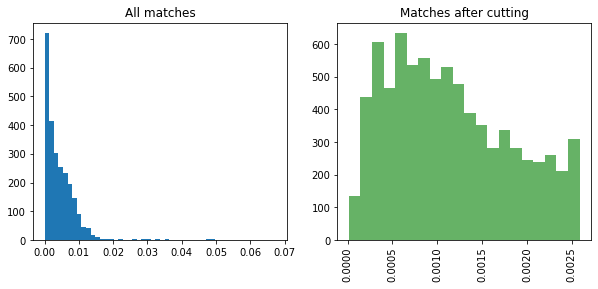

In [341]:
df = cut_mismatch(df3044)

- Check magnitude

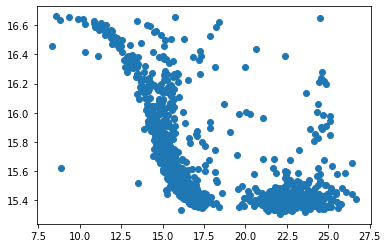

In [342]:
plt.scatter(df['g'], df['Magnitude'])

In [333]:
df['pg'] = df['g']+0.3*(df['u']-df['g'])-0.45

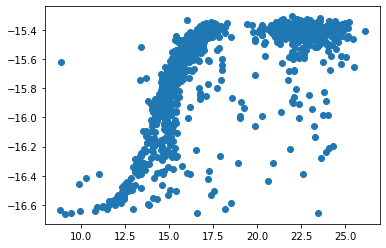

In [334]:
#plt.figure(figsize = (15,10))
plt.scatter(df['pg'], df['Magnitude'])

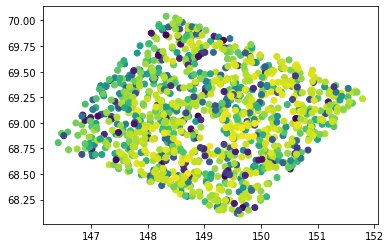

In [335]:
plt.scatter(df['ra'], df['dec'], c = df['Magnitude'] )

## fit regression and see the color difference
- https://scipy-cookbook.readthedocs.io/items/robust_regression.html

In [70]:
x = df['Magnitude']
y = df['pg']
p = np.poly1d(np.polyfit(x, y, 3))

In [71]:
testmag = np.arange(df['Magnitude'].min(), df['Magnitude'].max(), 0.01)
testpg = p(testmag)

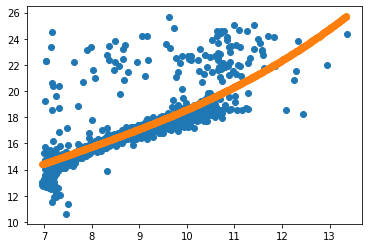

In [72]:
plt.scatter(df['Magnitude'], df['pg'])
plt.scatter(testmag, testpg)

In [73]:
df['pg_pred'] = p(df['Magnitude'])
df['diff_mag'] = df['pg_pred'] - df['pg']

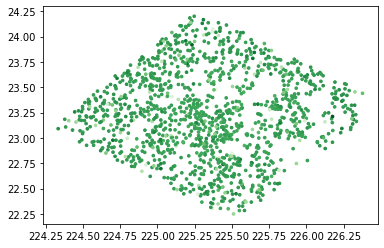

In [80]:
plt.scatter(df['ra'], df['dec'], c = df['diff_mag'], cmap = 'Greens', s = 7)

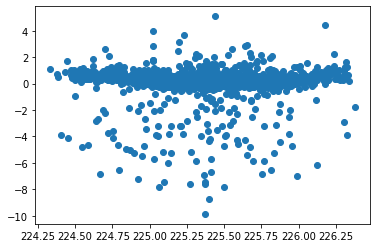

In [83]:
plt.scatter(df['ra'], df['diff_mag'])

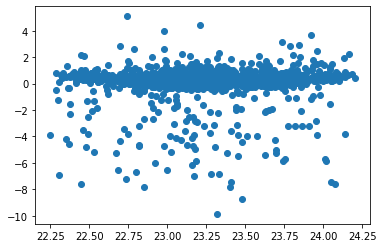

In [84]:
plt.scatter(df['dec'], df['diff_mag'])

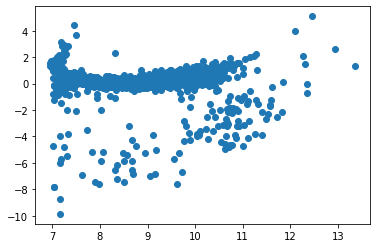

In [85]:
plt.scatter(df['Magnitude'], df['diff_mag'])

In [118]:
#linear regression on mag?
# import statsmodels.api as sm
# df_ = df_.dropna(subset=['u', 'g','r','i', 'z', 'Magnitude'])

# X = df_[['u', 'g', 'r', 'i', 'z']]
# y = df_['Magnitude']
# model = sm.OLS(y, X).fit()
# predictions = model.predict(X)
# model.summary()

In [122]:
# df_['cor_mag'] = predictions

# plt.scatter(df_['cor_mag'], df_['Magnitude'])
# plt.scatter(df_['cor_mag'], df_['g'])

## Identify QSO

In [15]:
df_['QSO'] = (df_.ra.isin(qso.ra) & df_.dec.isin(qso.dec))

In [16]:
df_qso = df_[df_['QSO'] == True].copy()
df_qso

,ra,dec,u,g,r,i,z,CentroidRA,CentroidDec,Magnitude,diff,pg,QSO
71,258.822909,43.686418,19.27667,18.95424,18.87252,18.87396,18.71936,258.822886,43.686486,9.5694,0.000072,18.600969,True
1330,257.855105,43.869076,19.03108,19.11633,19.14460,18.64607,18.69771,257.854670,43.868875,10.4625,0.000479,18.640755,True


In [20]:
list(df_[df_['QSO'] == True].index)

[71, 1330]

Text(0, 0.5, 'pg')

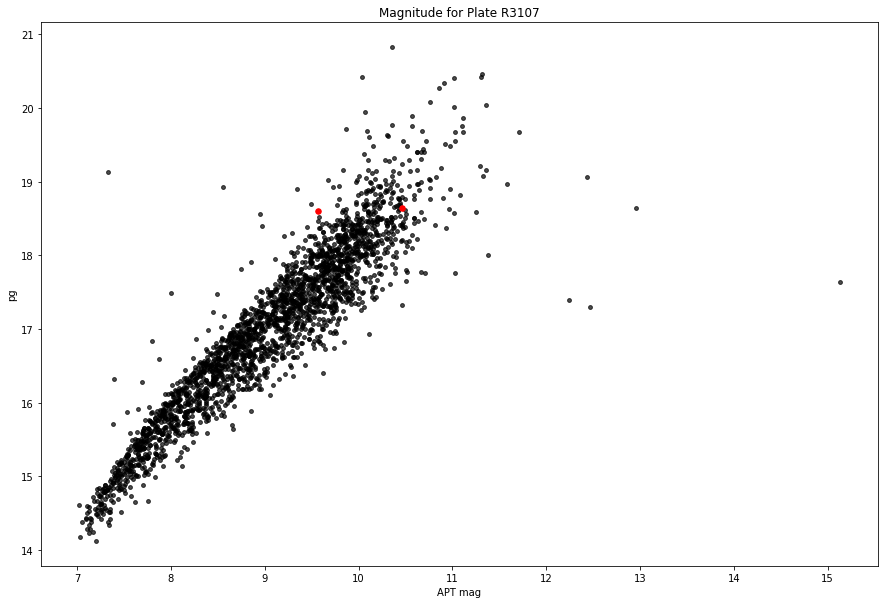

In [143]:
plt.figure(figsize = (15,10))
plt.scatter(df_['Magnitude'], df_['pg'], color = 'black', s = 15, alpha = 0.7)
plt.scatter(df_qso['Magnitude'], df_qso['pg'], color = 'red', s = 30)
plt.title("Magnitude for Plate R3107")
plt.xlabel("APT mag")
plt.ylabel("pg")

Text(0, 0.5, 'Dec')

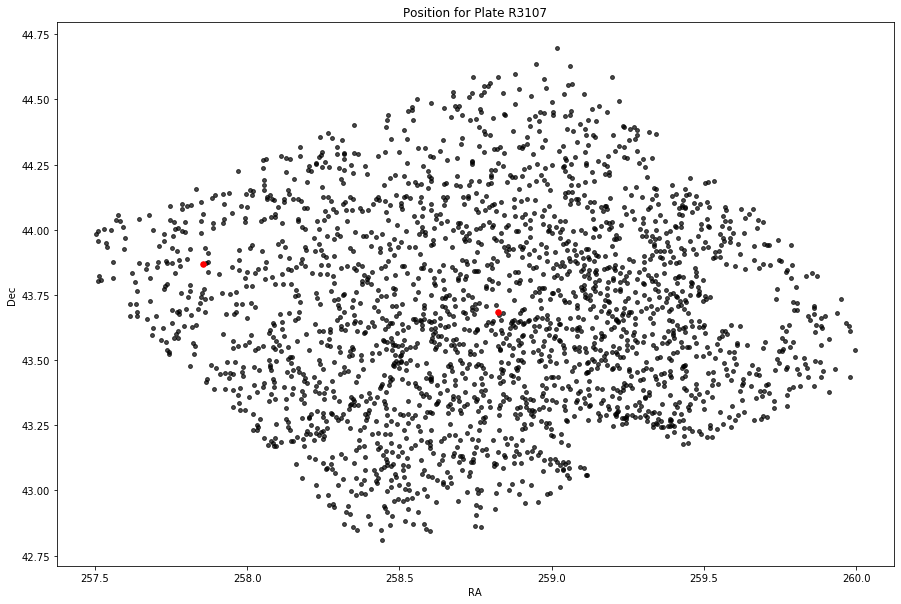

In [64]:
plt.figure(figsize = (15,10))
plt.scatter(df_['ra'], df_['dec'], color = 'black', s = 15, alpha = 0.7)
plt.scatter(df_qso['ra'], df_qso['dec'], color = 'red', s = 30)
plt.title("Position for Plate R3107")
plt.xlabel("RA")
plt.ylabel("Dec")

## Pick calibration stars

In [27]:
#qso1
qso1_ra = df_qso.iloc[0]['ra']
qso1_dec = df_qso.iloc[0]['dec']
qso1_pg = df_qso.iloc[0]['pg']
qso1_mag = df_qso.iloc[0]['Magnitude']

In [28]:
df_cal = df_[(df_['ra'] <= qso1_ra + 0.2)&(df_['ra'] >= qso1_ra - 0.2)\
            &(df_['dec'] <= qso1_dec + 0.2)&(df_['dec'] >= qso1_dec - 0.2)
            &(df_['pg'] <= qso1_pg + 1)&(df_['pg'] >= qso1_pg - 2)].copy()
df_cal = df_cal.dropna(subset=['pg', 'Magnitude'])
len(df_cal)

145

Text(0, 0.5, 'pg')

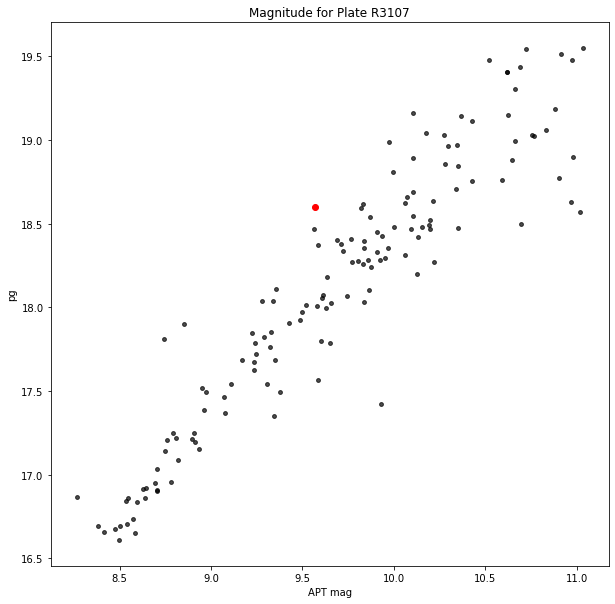

In [29]:
plt.figure(figsize = (10,10))
plt.scatter(df_cal['Magnitude'], df_cal['pg'], color = 'black', s = 15, alpha = 0.7)
plt.scatter([df_qso.iloc[0]['Magnitude']], [df_qso.iloc[0]['pg']], color = 'red')
plt.title("Magnitude for Plate R3107")
plt.xlabel("APT mag")
plt.ylabel("pg")

In [5]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

X = df_cal['Magnitude']
X = sm.add_constant(X)
y = df_cal['pg']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

NameError: name 'df_cal' is not defined

Text(20.625, 0.5, 'pg')

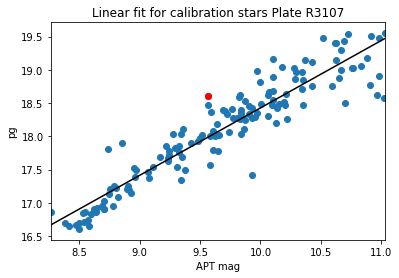

In [146]:
fig = abline_plot(model_results = model, color = 'black')
ax = fig.axes[0]
ax.scatter(df_cal['Magnitude'], df_cal['pg'])
ax.scatter([qso1_mag], [qso1_pg], color = 'red')

plt.title("Linear fit for calibration stars Plate R3107")
plt.xlabel("APT mag")
plt.ylabel("pg")

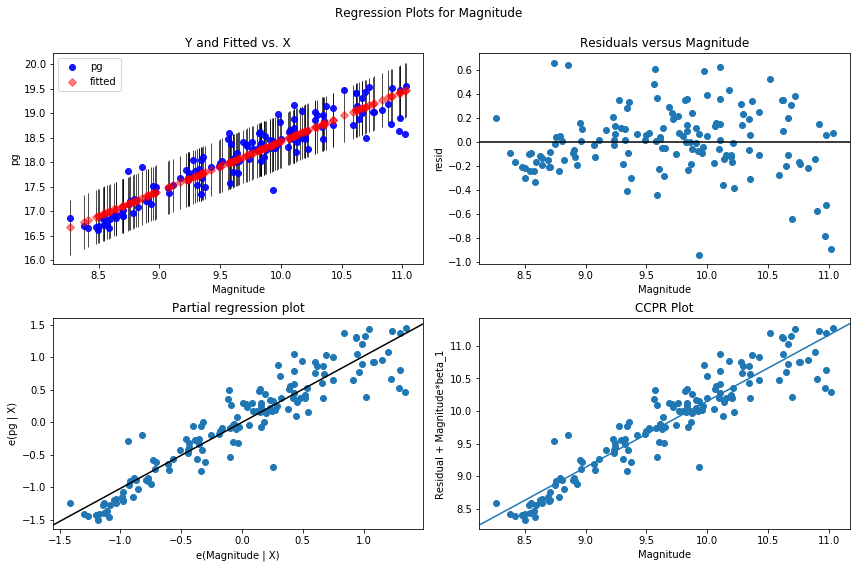

In [147]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "Magnitude", fig=fig)

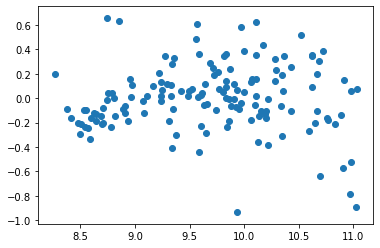

In [33]:
plt.scatter(df_cal['Magnitude'], df_cal['res'])
abline_plot(model_results = model, color = 'black')

Text(0.5, 1.0, 'Histogram for residuals')

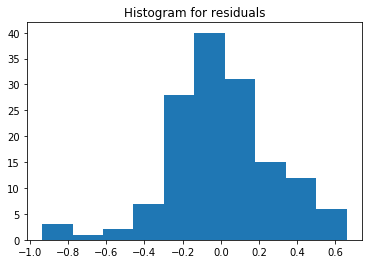

In [64]:
df_cal['res'] = df_cal['pg'] - predictions
plt.hist(df_cal['res'])
plt.title("Histogram for residuals")

In [77]:
(np.quantile(df_cal['res'], 0.16), np.quantile(df_cal['res'], 0.84))

(-0.20991175310075633, 0.2520672080332587)

In [99]:
df_cal.loc[df_cal['QSO'] == True]['res'].values[0]

0.6101155252419517

In [86]:
"{0}/{0}.txt".format("R3170")

'R3170/R3170.txt'

In [84]:
file1 = open("{}/{}.txt".format("R3170"), "w") 
file1.write("\n------------------QSO {}-------------------\n".format(1))

IndexError: tuple index out of range

In [83]:
df_cal.iloc[2]

ra                 258.823
dec                43.6864
u                  19.2767
g                  18.9542
r                  18.8725
i                   18.874
z                  18.7194
CentroidRA         258.823
CentroidDec        43.6865
Magnitude           9.5694
diff           7.17274e-05
pg                  18.601
QSO                   True
res               0.610116
Name: 71, dtype: object

In [34]:
df_cal['res']

19     -0.207458
28     -0.079965
71      0.610116
87      0.358675
90     -0.210014
          ...   
2286   -0.094085
2291    0.351290
2324    0.199430
2336    0.484400
2355    0.152846
Name: res, Length: 145, dtype: float64

In [42]:
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95
data = list(df_cal['res'])

n = len(data)
m = mean(data)
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

print(m-h, m+h)

-0.044973327244233564 0.04497332724424003


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  import sys


In [165]:
import statsmodels.stats.api as sm
sm.DescrStatsW(res_qso1).tconfint_mean(alpha=0.05)

(-0.04497332724423357, 0.04497332724424004)

In [171]:
df_cal[df_cal['QSO'] == True]

,ra,dec,u,g,r,i,z,CentroidRA,CentroidDec,Magnitude,diff,del_ra,del_dec,pg,QSO,res
71,258.822909,43.686418,19.27667,18.95424,18.87252,18.87396,18.71936,258.822886,43.686486,9.5694,0.000072,-0.081383,0.245058,18.600969,True,0.610116


In [180]:
import numpy as np, scipy.stats as st
a = df_cal['res']
st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(-0.044973327244233564, 0.04497332724424003)

In [183]:
from scipy.stats import sem, t
sem(df_cal['res'])

0.02275315925105658

In [184]:
#qso2
qso1_ra = df_qso.iloc[1]['ra']
qso1_dec = df_qso.iloc[1]['dec']
qso1_pg = df_qso.iloc[1]['pg']
qso1_mag = df_qso.iloc[1]['Magnitude']

In [187]:
boxsize = 0.3
df_cal = df_[(df_['ra'] <= qso1_ra + boxsize)&(df_['ra'] >= qso1_ra - boxsize)\
            &(df_['dec'] <= qso1_dec + boxsize)&(df_['dec'] >= qso1_dec - boxsize)
            &(df_['pg'] <= qso1_pg + 1)&(df_['pg'] >= qso1_pg - 2)].copy()
df_cal = df_cal.dropna(subset=['pg', 'Magnitude'])
len(df_cal)

104

Text(0, 0.5, 'pg')

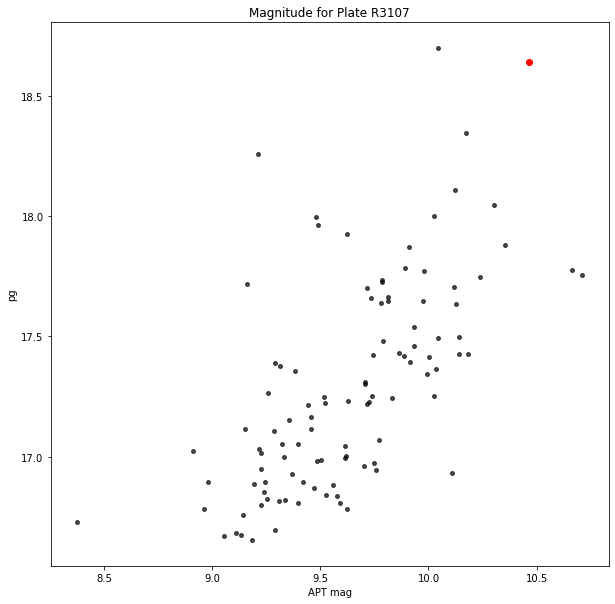

In [188]:
plt.figure(figsize = (10,10))
plt.scatter(df_cal['Magnitude'], df_cal['pg'], color = 'black', s = 15, alpha = 0.7)
plt.scatter([qso1_mag], [qso1_pg], color = 'red')
plt.title("Magnitude for Plate R3107")
plt.xlabel("APT mag")
plt.ylabel("pg")

In [189]:
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

X = df_cal['Magnitude']
X = sm.add_constant(X)
y = df_cal['pg']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pg   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     73.04
Date:                Sat, 23 May 2020   Prob (F-statistic):           1.32e-13
Time:                        11:36:12   Log-Likelihood:                -35.150
No. Observations:                 104   AIC:                             74.30
Df Residuals:                     102   BIC:                             79.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3084      0.819     12.593      0.000       8.685      11.932
Magnitude      0.7257      0.085      8.546      0.000       0.557       0.894
==============================================================================
Omnibus:                       26.383   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.265
Skew:                           1.181   Prob(JB):                     2.98e-09
Kurtosis:                       4.866   Cond. No.                         237.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(20.625, 0.5, 'pg')

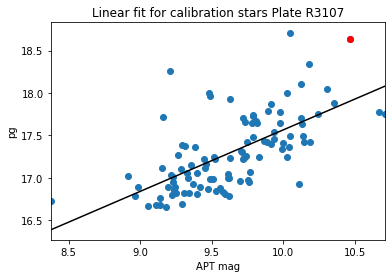

In [190]:
fig = abline_plot(model_results = model, color = 'black')
ax = fig.axes[0]
ax.scatter(df_cal['Magnitude'], df_cal['pg'])
ax.scatter([qso1_mag], [qso1_pg], color = 'red')

plt.title("Linear fit for calibration stars Plate R3107")
plt.xlabel("APT mag")
plt.ylabel("pg")

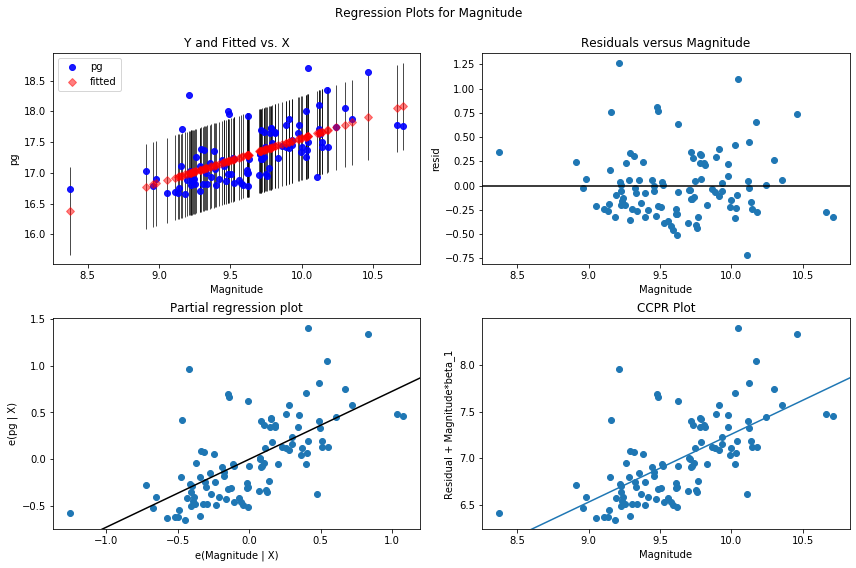

In [191]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "Magnitude", fig=fig)

Text(0.5, 1.0, 'Histogram for residuals')

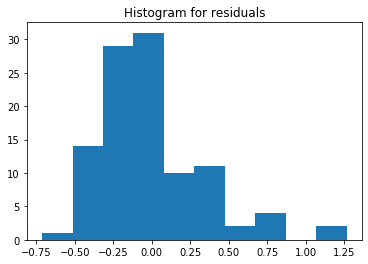

In [192]:
df_cal['res'] = df_cal['pg'] - predictions
plt.hist(df_cal['res'])
plt.title("Histogram for residuals")

In [165]:
import statsmodels.stats.api as sm
sm.DescrStatsW(res_qso1).tconfint_mean(alpha=0.05)

(-0.04497332724423357, 0.04497332724424004)

In [193]:
df_cal[df_cal['QSO'] == True]

,ra,dec,u,g,r,i,z,CentroidRA,CentroidDec,Magnitude,diff,del_ra,del_dec,pg,QSO,res
1330,257.855105,43.869076,19.03108,19.11633,19.1446,18.64607,18.69771,257.85467,43.868875,10.4625,0.000479,-1.565208,-0.722843,18.640755,True,0.739619


In [180]:
import numpy as np, scipy.stats as st
a = df_cal['res']
st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

(-0.044973327244233564, 0.04497332724424003)

In [183]:
from scipy.stats import sem, t
sem(df_cal['res'])

0.02275315925105658

## Effects of radial distance 

In [7]:
df = pd.read_csv("R3170/R3170_match.csv")

In [11]:
meanra = np.mean(df.ra)
meandec = np.mean(df.dec)

In [33]:
df['radial_dist'] = np.sqrt((df.ra - meanra)**2 + (df.dec - meandec)**2)*60 #acrmin

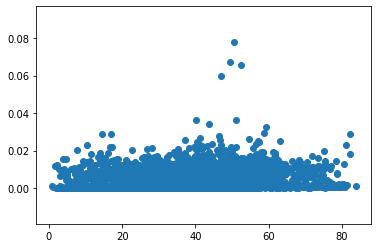

In [34]:
plt.scatter(df['radial_dist'], df['diff'])

In [35]:
diff_lim = 0.001
df_clean = df[df['diff'] <= diff_lim].copy()
df_clean['pg'] = df_clean['g'] + 0.3*(df_clean['u'] - df_clean['g']) - 0.45

In [36]:
#import statsmodels.api as sm
#from statsmodels.graphics.regressionplots import abline_plot
df_clean = df_clean.dropna(subset=['pg', 'Magnitude'])
X = df_clean['Magnitude']
X = sm.add_constant(X)
y = df_clean['pg']
model = sm.OLS(y, X).fit()
df_clean['pred_pg'] = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 1.407e+04
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        22:56:37   Log-Likelihood:                -1402.1
No. Observations:                2376   AIC:                             2808.
Df Residuals:                    2374   BIC:                             2820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6124      0.088     75.064      0.000       6.440       6.785
Magnitude      1.1494      0.010    118.623      0.000       1.130       1.168
==============================================================================
Omnibus:                     1034.610   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74226.907
Skew:                          -1.189   Prob(JB):                         0.00
Kurtosis:                      30.278   Cond. No.                         90.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

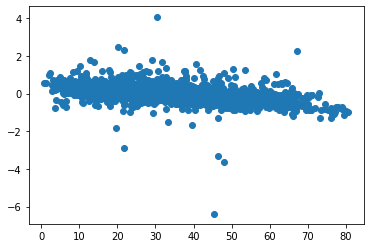

In [38]:
plt.scatter(df_clean['radial_dist'], df_clean['pg'] - df_clean['pred_pg'])

In [39]:
#import statsmodels.api as sm
#from statsmodels.graphics.regressionplots import abline_plot
df_clean = df_clean.dropna(subset=['pg', 'Magnitude'])
X = df_clean['radial_dist']
X = sm.add_constant(X)
y = df_clean['pg'] - df_clean['pred_pg']
model = sm.OLS(y, X).fit()
df_clean['pg_cor_by_rad'] = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     800.1
Date:                Sun, 31 May 2020   Prob (F-statistic):          6.18e-152
Time:                        23:00:08   Log-Likelihood:                -1057.1
No. Observations:                2376   AIC:                             2118.
Df Residuals:                    2374   BIC:                             2130.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5077      0.020     25.969      0.000       0.469       0.546
radial_dist    -0.0143      0.001    -28.285      0.000      -0.015      -0.013
==============================================================================
Omnibus:                     1321.334   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           211335.125
Skew:                          -1.571   Prob(JB):                         0.00
Kurtosis:                      49.096   Cond. No.                         97.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

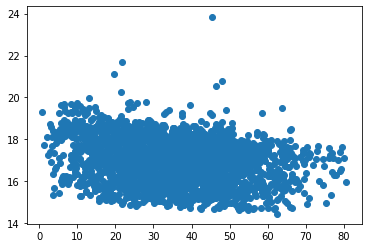

In [46]:
plt.scatter(df_clean['radial_dist'], df_clean['pred_pg'] + df_clean['pg_cor_by_rad'])

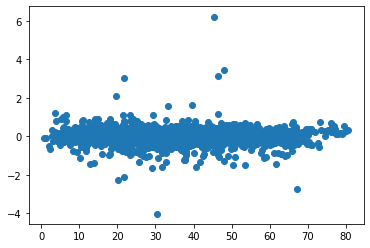

In [47]:
plt.scatter(df_clean['radial_dist'], (df_clean['pred_pg'] + df_clean['pg_cor_by_rad']) - df_clean['pg'])

## Query for calibration stars in SDSS (manual version)

##### Query used to find calibration stars in this field:
select ra, dec, u, g, r, i, z, modelmagerr_u, modelmagerr_g,
modelmagerr_r, modelmagerr_i, modelmagerr_z

from star

where (ra between 257.5 and 260.0) and (dec between 42.75 and 44.75)  and
modelmag_g < 21.0 and clean = 1

In [2]:
import pandas as pd

In [3]:
cal = pd.read_csv("starmatch/R3170/R3170_cal.csv", skiprows=1)

In [61]:
cal

,ra,dec,u,g,r,i,z,modelmagerr_u,modelmagerr_g,modelmagerr_r,modelmagerr_i,modelmagerr_z
0,257.601958,43.846779,21.02859,19.37385,18.57005,18.23596,18.01619,0.085561,0.010881,0.008572,0.008546,0.021753
1,257.656208,43.879545,19.76678,18.48773,18.02563,17.87258,17.82726,0.036282,0.007191,0.006880,0.007315,0.019296
2,257.539991,43.877754,21.84438,19.27183,17.90633,17.18915,16.82446,0.158271,0.010358,0.006630,0.005831,0.010596
3,257.605856,43.931044,19.62954,17.63739,16.86649,16.56941,16.41286,0.033184,0.005402,0.005052,0.004978,0.008656
4,257.527278,43.923812,22.68600,20.21087,19.00655,18.48268,18.24481,0.314642,0.017629,0.010544,0.009668,0.025595
...,...,...,...,...,...,...,...,...,...,...,...,...
15587,259.988455,44.009039,18.42010,17.17168,16.70322,16.54759,16.48762,0.015448,0.005387,0.004709,0.005456,0.008379
15588,259.976804,43.840368,18.30698,17.02498,16.57518,16.43489,16.40039,0.014725,0.005269,0.004490,0.005280,0.008076
15589,259.992061,43.922334,18.13978,17.12185,16.77095,16.75656,16.67050,0.013561,0.005271,0.004687,0.005335,0.008986
15590,259.999252,43.877324,18.76302,17.42209,16.89761,16.73048,16.67255,0.018615,0.005635,0.004797,0.005582,0.008963


In [3]:
#do this from python
from astroquery.sdss import SDSS
from astropy import coordinates as coords

## Query for QSO in SDSS

##### Query used for QSO in this field:
select p.ra, p.dec, s.z, snMedian, p.u, p.g, p.r, p.i, p.z, p.modelmagerr_u, p.modelmagerr_g,
p.modelmagerr_r, p.modelmagerr_i, p.modelmagerr_z

from photoobj as p, specobj as s

where p.specobjid = s.specobjid and snMedian > 7.0 and s.class = 'QSO' 
and (p.ra between 257.5 and 260.0) and (p.dec between 42.75 and 44.75) 

In [4]:
qso = pd.read_csv("starmatch/R3170/R3170_QSO.csv", skiprows=1)

In [5]:
qso

,ra,dec,z,snMedian,u,g,r,i,z1,modelmagerr_u,modelmagerr_g,modelmagerr_r,modelmagerr_i,modelmagerr_z
0,258.822909,43.686418,2.421538,16.707820,19.27667,18.95424,18.87252,18.87396,18.71936,0.023274,0.009167,0.009716,0.012224,0.030149
1,258.363740,44.370968,2.608278,16.485430,20.16723,18.75215,18.62946,18.42419,18.02144,0.039606,0.008181,0.008705,0.009651,0.019685
2,258.913649,43.412356,0.782486,8.419252,20.77716,19.82656,19.54265,19.47729,19.14109,0.058187,0.014286,0.014299,0.019598,0.054579
3,257.731946,42.886099,1.086822,9.131435,19.72837,19.60237,19.35447,19.37905,19.41620,0.033607,0.013398,0.013753,0.016021,0.054806
4,258.240411,43.122332,1.160563,22.291000,18.72164,18.66474,18.52683,18.49721,18.48767,0.019436,0.007765,0.008420,0.009448,0.029767
5,257.734048,42.802318,0.815241,9.663289,19.20997,18.89720,18.81041,18.93487,18.85936,0.024563,0.008866,0.009823,0.012118,0.035591
6,258.002519,43.495556,1.458988,10.702320,19.33221,19.28545,19.04951,18.90976,18.99333,0.024217,0.010542,0.010842,0.013225,0.048202
7,257.749153,43.126178,1.914229,9.714561,20.29676,20.27546,20.37876,19.82082,19.71232,0.049697,0.020005,0.029299,0.026688,0.084616
8,257.768843,42.783808,1.873098,7.634579,20.82107,20.64220,20.50129,20.20028,20.14550,0.071943,0.026949,0.031036,0.029170,0.100482
9,258.694431,42.821437,2.292792,7.651306,20.88832,19.95499,19.81912,19.66104,19.39292,0.068128,0.015394,0.016365,0.020176,0.050959
